In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import wbdata as wb
import sys
#!{sys.executable} -m pip install --user geopandas
import geopandas as gpd
import json as json
from bokeh.io import output_notebook, show, curdoc, push_notebook, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool, FuncTickFormatter, SingleIntervalTicker, Slider, CustomJS
from bokeh.palettes import brewer 
from bokeh.layouts import column, widgetbox
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler
from bokeh.resources import INLINE
import bokeh.io
bokeh.io.output_notebook(INLINE)
import statsmodels.formula.api as sm
#import sys
#!{sys.executable} -m pip install ipywidgets
from ipywidgets import interact

Loading BokehJS ...

In [2]:
#wb.search_indicators("country")
indicators = {"ny.gdp.pcap.pp.cd" : "gdp"} #I use GDP per capita, PPP (in current US dollars) (also called real GDP)
rename = {"Congo, Dem. Rep.": "Democratic Republic of the Congo", "Congo, Rep.": "Republic of the Congo", "Cote d'Ivoire": "Ivory Coast", "Czech Republic": "Czechia",
          "Egypt, Arab Rep.": "Egypt", "Eswatini": "eSwatini", "Gambia, The": "Gambia", "Iran, Islamic Rep.": "Iran", "Korea, Rep.": "South Korea", "Kyrgyz Republic": "Kyrgyzstan",
          "Lao PDR": "Laos", "North Macedonia": "Macedonia", "Russian Federation": "Russia", "Serbia": "Republic of Serbia", "Slovak Republic": "Slovakia",
          "Syrian Arab Republic": "Syria", "Tanzania": "United Republic of Tanzania", "United States": "United States of America", "Venezuela, RB": "Venezuela", "Yemen, Rep.": "Yemen"}

gdp_data = wb.get_dataframe(indicators, country="all")
gdp_data.reset_index(inplace = True)
gdp_data["date"] = pd.to_numeric(gdp_data["date"], downcast="integer")
gdp_data.at[9150:9210, "country"] = "North Korea"

#Add rows for countries Palestine, Somaliland and Western Sahara which are not recognized by the Worldbank:
for i in np.arange(0,61): #Every country has 61 rows (years 1960 to 2020)
    gdp_data = gdp_data.append(pd.Series(), ignore_index = True) #Add empty row at bottom of df
    gdp_data.loc[[len(gdp_data)-1], "country"] = "Palestine"
    gdp_data.loc[[len(gdp_data)-1], "date"] = 2020 - i 

for i in np.arange(0,61): #Every country has 61 rows (years 1960 to 2020)
    gdp_data = gdp_data.append(pd.Series(), ignore_index = True) #Add empty row at bottom of df
    gdp_data.loc[[len(gdp_data)-1], "country"] = "Somaliland"
    gdp_data.loc[[len(gdp_data)-1], "date"] = 2020 - i 

for i in np.arange(0,61):
    gdp_data = gdp_data.append(pd.Series(), ignore_index = True) 
    gdp_data.loc[[len(gdp_data)-1], "country"] = "Western Sahara"
    gdp_data.loc[[len(gdp_data)-1], "date"] = 2020 - i

#Rename countries to match data
gdp_data["country"] = gdp_data["country"].replace(rename)

#Add log_gdp to dataframe
gdp_data["log_gdp"] = np.log(gdp_data["gdp"])
#Add growth_gdp and growth_log_gdp to dataframe
gdp_data["growth_gdp"] = (gdp_data["gdp"] - gdp_data["gdp"].shift(-1)) / gdp_data["gdp"].shift(-1)
gdp_data["growth_log_gdp"] = (gdp_data["log_gdp"] - gdp_data["log_gdp"].shift(-1)) / gdp_data["log_gdp"].shift(-1)

gdp_data["gdp_shift"] = gdp_data["gdp"].shift(-1)
gdp_data["log_gdp_shift"] = gdp_data["log_gdp"].shift(-1)

gdp_data.head()

#gdp_data.to_csv('Data/worldbank_data_gdp_per_capita_ppp.csv')

<ipython-input-2-d264e044cbc3>:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  gdp_data = gdp_data.append(pd.Series(), ignore_index = True) #Add empty row at bottom of df
<ipython-input-2-d264e044cbc3>:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  gdp_data = gdp_data.append(pd.Series(), ignore_index = True) #Add empty row at bottom of df
<ipython-input-2-d264e044cbc3>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  gdp_data = gdp_data.append(pd.Series(), ignore_index = True)


country    date           gdp   log_gdp  growth_gdp  growth_log_gdp  \
0  Arab World  2020.0           NaN       NaN         NaN             NaN   
1  Arab World  2019.0  15256.376720  9.632753    0.018086        0.001864   
2  Arab World  2018.0  14985.352890  9.614829    0.029046        0.002987   
3  Arab World  2017.0  14562.367966  9.586196    0.038251        0.003931   
4  Arab World  2016.0  14025.865608  9.548658   -0.040550       -0.004316   

      gdp_shift  log_gdp_shift  
0  15256.376720       9.632753  
1  14985.352890       9.614829  
2  14562.367966       9.586196  
3  14025.865608       9.548658  
4  14618.653949       9.590054

In [3]:
dflandlocked = pd.read_csv('Data/landlocked.csv', sep = ';')
dflandlocked.head()

Country Continent
0  Afghanistan      Asia
1      Andorra    Europe
2      Armenia      Asia
3      Austria    Europe
4   Azerbaijan      Asia

In [4]:
dfgdp = gdp_data.assign(landlocked = gdp_data["country"].isin(dflandlocked["Country"]).astype(int)) #Where dataframes overlap, landlocked = 1, otherwise landlocked = 0
#pd.get_dummies(dfgdp["landlocked"])
dfgdp.tail()

country    date  gdp  log_gdp  growth_gdp  growth_log_gdp  \
16282  Western Sahara  1964.0  NaN      NaN         NaN             NaN   
16283  Western Sahara  1963.0  NaN      NaN         NaN             NaN   
16284  Western Sahara  1962.0  NaN      NaN         NaN             NaN   
16285  Western Sahara  1961.0  NaN      NaN         NaN             NaN   
16286  Western Sahara  1960.0  NaN      NaN         NaN             NaN   

       gdp_shift  log_gdp_shift  landlocked  
16282        NaN            NaN           0  
16283        NaN            NaN           0  
16284        NaN            NaN           0  
16285        NaN            NaN           0  
16286        NaN            NaN           0

In [5]:
worldmap = "Data/ne_110m_admin_0_countries.shp"
worldmap = gpd.read_file(worldmap)[['ADMIN', 'ADM0_A3', 'geometry']]
worldmap.columns = ['country', 'country_code', 'geometry']
worldmap = worldmap.drop(worldmap.index[159]) #Remove Antarctica as there is no available gdp data, and it takes up a lot of space on the map
worldmap.head()

country country_code  \
0                         Fiji          FJI   
1  United Republic of Tanzania          TZA   
2               Western Sahara          SAH   
3                       Canada          CAN   
4     United States of America          USA   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

In [6]:
#pd.set_option("max_rows", None)
#worldmap

In [7]:
dfgdp_merged = worldmap.merge(dfgdp, how="left", on="country")
dfgdp_merged.fillna("NaN", inplace = True)
dfgdp_merged.head()

country country_code                                           geometry  \
0    Fiji          FJI  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1    Fiji          FJI  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
2    Fiji          FJI  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
3    Fiji          FJI  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
4    Fiji          FJI  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   

     date           gdp   log_gdp growth_gdp growth_log_gdp     gdp_shift  \
0  2020.0           NaN       NaN        NaN            NaN  14289.960502   
1  2019.0  14289.960502  9.567313   0.007501       0.000782  14183.563896   
2  2018.0  14183.563896  9.559839   0.056164       0.005749  13429.315918   
3  2017.0  13429.315918  9.505195   0.063118       0.006481  12632.013532   
4  2016.0  12632.013532  9.443990   0.017691       0.001860  12412.422182   

  log_gdp_shift landlocked  
0      9.567313        0.0  
1      9.559839        0.0  
2      9.505195        0.0  
3      9.443990        0.0  
4      9.426453        0.0

In [8]:
dfgdp_merged_2015 = dfgdp_merged[dfgdp_merged["date"] == 2015]
#dfgdp_merged_2015.head()
dfgdp_merged_2015_json = json.loads(dfgdp_merged_2015.to_json())
#dfgdp_2015.coordinate.__geo_interface__
dfgdp_merged_2015_json_data = json.dumps(dfgdp_merged_2015_json)

In [9]:


#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = dfgdp_merged_2015_json_data)
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette=['blue','red'], low=0, high=1, nan_color="lightgrey") #Works now!! 
#Create figure object.
p = figure(title = 'Landlocked Countries', plot_height = 600 , plot_width = 1000,
          tools = "pan, wheel_zoom, zoom_in, zoom_out, reset", active_scroll = "wheel_zoom", toolbar_location = "right")
#Remove both the x- and y-axis and the x- and y-lines from plot
p.axis.visible = False
p.grid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource, fill_color = {'field' : 'landlocked', 'transform' : color_mapper},
          line_color = 'gray', line_width = 0.75)
#Add hovertool
hover = HoverTool(tooltips=[('Country', '@country'), ('Landlocked', '@landlocked')])
p.add_tools(hover)
#Display figure inline in Jupyter Notebook.
output_notebook()
#Display figure.
show(p)

Loading BokehJS ...

In [10]:
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = dfgdp_merged_2015_json_data)
#Define a sequential multi-hue color palette.
palette = brewer["Greens"][9]
#Reverse color order
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette=palette, low = 0, high = 45000, nan_color = "lightgrey")
#Define custom tick labels for color bar.
ticker_labels = SingleIntervalTicker(interval = 5000)
formatter = FuncTickFormatter(code = """
    var data = {'0': '0$', '5000': '5,000$', '10000':'10,000$', '15000':'15,000$', '20000':'20,000$', '25000':'25,000$',
            '30000':'30,000$','35000':'35,000$', '40000': '40,000$', '45000': '>45,000$'}
    return data[tick]
""")
#Create color bar. 
color_bar = ColorBar(color_mapper = color_mapper, ticker = ticker_labels, formatter = formatter, 
                     label_standoff = 5, width = 650, height = 22, location = (0,0), orientation = 'horizontal')
#Create figure object.
p = figure(title = "GDP per capita in $ (2015)", plot_width = 1000, plot_height = 600, 
           tools = "pan, wheel_zoom, zoom_in, zoom_out, reset", active_scroll = "wheel_zoom", toolbar_location = "right")
#Remove both the x- and y-axis and the x- and y-lines from plot
p.axis.visible = False
p.grid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource, fill_color = {'field' : 'gdp', 'transform' : color_mapper},
          line_color = 'gray', line_width = 0.75)
#Specify figure layout.
p.add_layout(color_bar, 'below')
#Add hovertool
hover = HoverTool(tooltips=[('Country', '@country'), ('GDP per capita', '$@gdp{0,0}'), ('Landlocked', '@landlocked')])
p.add_tools(hover)
#Display figure inline in Jupyter Notebook.
output_notebook()
#Display figure.
show(p)

Loading BokehJS ...

In [11]:
def data_slider(year):
    dfgdp_selected_year = dfgdp[dfgdp["date"] == year]
    dfgdp_merged_selected_year = worldmap.merge(dfgdp_selected_year, how="left", on="country")
    dfgdp_merged_selected_year.fillna("NaN", inplace = True)
    dfgdp_merged_selected_year_json = json.loads(dfgdp_merged_selected_year.to_json())
    data_slider = json.dumps(dfgdp_merged_selected_year_json)
    return data_slider


In [12]:
#Initial year (default year that is selected by slider)
year_initial = 2015
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = data_slider(year_initial))
#Define a sequential multi-hue color palette.
palette = brewer["Greens"][9]
#Reverse color order
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette=palette, low = 0, high = 45000, nan_color = "lightgrey")
#Define custom tick labels for color bar.
ticker_labels = SingleIntervalTicker(interval = 5000)
formatter = FuncTickFormatter(code = """
    var data = {'0': '0$', '5000': '5,000$', '10000':'10,000$', '15000':'15,000$', '20000':'20,000$', '25000':'25,000$',
            '30000':'30,000$','35000':'35,000$', '40000': '40,000$', '45000': '>45,000$'}
    return data[tick]
""")
#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, ticker = ticker_labels, formatter = formatter, 
                     label_standoff = 5, width = 650, height = 22, location = (0,0), orientation = 'horizontal')
#Create figure object.
p = figure(title = "GDP per capita in $ (2015)", plot_width = 1000, plot_height = 600, 
           tools = "pan, wheel_zoom, zoom_in, zoom_out, reset", active_scroll = "wheel_zoom", toolbar_location = "right")
#Remove both the x- and y-axis and the x- and y-lines from plot
p.axis.visible = False
p.grid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource, fill_color = {'field' : 'gdp', 'transform' : color_mapper},
          line_color = 'gray', line_width = 0.75)
#Define slider
slider = Slider(title = "Year", start = 1990, end = 2015, value = year_initial) 
#Define callback function for slider to select different years
def callback(attr, old, new):
    year = slider.value
    geosource.geojson = data_slider(year) #new_data = data_slider(year)
    #geosource.geojson = new_data
    p.title.text = "GDP per capita in $ (%year)"
slider.on_change("value", callback)
#And add slider to plot p
layout = column(widgetbox(slider), p)
curdoc().add_root(layout)
#Specify figure layout.
p.add_layout(color_bar, 'below')
#Add hovertool
hover = HoverTool(tooltips=[('Country', '@country'), ('GDP per capita', '$@gdp{0,0}'), ('Landlocked', '@landlocked')])
p.add_tools(hover)
#Display figure inline in Jupyter Notebook.

#Display figure.
show(layout)

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



In [13]:
#Initial year (default year that is selected by slider)
year_initial = 2015
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = data_slider(year_initial))
#Define a sequential multi-hue color palette.
palette = brewer["Greens"][9]
#Reverse color order
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette=palette, low = 0, high = 45000, nan_color = "lightgrey")
#Define custom tick labels for color bar.
ticker_labels = SingleIntervalTicker(interval = 5000)
formatter = FuncTickFormatter(code = """
    var data = {'0': '0$', '5000': '5,000$', '10000':'10,000$', '15000':'15,000$', '20000':'20,000$', '25000':'25,000$',
            '30000':'30,000$','35000':'35,000$', '40000': '40,000$', '45000': '>45,000$'}
    return data[tick]
""")
#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, ticker = ticker_labels, formatter = formatter, 
                     label_standoff = 5, width = 650, height = 22, location = (0,0), orientation = 'horizontal')
#Create figure object.
p = figure(title = "GDP per capita in $ (2015)", plot_width = 1000, plot_height = 600, 
           tools = "pan, wheel_zoom, zoom_in, zoom_out, reset", active_scroll = "wheel_zoom", toolbar_location = "right")
#Remove both the x- and y-axis and the x- and y-lines from plot
p.axis.visible = False
p.grid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource, fill_color = {'field' : 'gdp', 'transform' : color_mapper},
          line_color = 'gray', line_width = 0.75)
#Define slider
slider = Slider(title = "Year", start = 1990, end = 2015, value = year_initial) 
#Define callback function for slider to select different years
callback = CustomJS(args=dict(source=geosource), code = """"
    var year = slider.value
    geosource.geojson = data_slider(year)
    source.change.emit();
""")

slider.js_on_change("value", callback)
#And add slider to plot p
layout = column(widgetbox(slider), p)
curdoc().add_root(layout)
#Specify figure layout.
p.add_layout(color_bar, 'below')
#Add hovertool
hover = HoverTool(tooltips=[('Country', '@country'), ('GDP per capita', '$@gdp{0,0}'), ('Landlocked', '@landlocked')])
p.add_tools(hover)
#Display figure inline in Jupyter Notebook.
#output_notebook()
#Display figure.
show(layout)

In [14]:
eu_states = {"Luxembourg", "Czechia", "Austria", "Slovakia", "Hungary"} #Landlocked countries that are EU member states
data1990 = dfgdp[(dfgdp["date"] > 1994) & (dfgdp["date"] < 2020)]
#data1990 = data1990[(data1990["country"] != "Luxembourg") | (data1990["country"] != "Austria")]
data1990 = data1990[~data1990["country"].isin(eu_states)]
factor = data1990["date"].astype(object)
lm2015 = sm.ols(formula="growth_gdp ~ landlocked + factor", data=data1990).fit()
print(lm2015.summary())
data1990.head()

                            OLS Regression Results                            
Dep. Variable:             growth_gdp   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     22.95
Date:                Mon, 04 Jan 2021   Prob (F-statistic):          8.69e-100
Time:                        16:34:51   Log-Likelihood:                 8235.5
No. Observations:                5743   AIC:                        -1.642e+04
Df Residuals:                    5717   BIC:                        -1.625e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0441      0.004  

country    date           gdp   log_gdp  growth_gdp  growth_log_gdp  \
1  Arab World  2019.0  15256.376720  9.632753    0.018086        0.001864   
2  Arab World  2018.0  14985.352890  9.614829    0.029046        0.002987   
3  Arab World  2017.0  14562.367966  9.586196    0.038251        0.003931   
4  Arab World  2016.0  14025.865608  9.548658   -0.040550       -0.004316   
5  Arab World  2015.0  14618.653949  9.590054   -0.098718       -0.010722   

      gdp_shift  log_gdp_shift  landlocked  
1  14985.352890       9.614829           0  
2  14562.367966       9.586196           0  
3  14025.865608       9.548658           0  
4  14618.653949       9.590054           0  
5  16219.840282       9.693990           0

In [15]:
dfgdp2019 = dfgdp[(dfgdp["date"] > 1989) & (dfgdp["date"] != 2020)]
meangdp_year = dfgdp2019.groupby("date")["gdp", "growth_gdp"].mean().reset_index()
meangdp_year_landlocked = dfgdp2019[dfgdp2019["landlocked"] == 1].groupby("date")["gdp", "growth_gdp"].mean().reset_index()
meangdp_year_notlandlocked = dfgdp2019[dfgdp2019["landlocked"] == 0].groupby("date")["gdp", "growth_gdp"].mean().reset_index()

meangdp_year = meangdp_year.merge(meangdp_year_landlocked, on = "date")
meangdp_year = meangdp_year.merge(meangdp_year_notlandlocked, on = "date")
meangdp_year.columns = ["date", "gdp_total", "gdp_total_growth", "gdp_landlocked", "gdp_landlocked_growth", "gdp_notlandlocked", "gdp_notlandlocked_growth"]
meangdp_year["gdp_total_growth_ma"] = (meangdp_year["gdp_total_growth"].shift(1) + meangdp_year["gdp_total_growth"] + meangdp_year["gdp_total_growth"].shift(-1)) / 3
meangdp_year["gdp_landlocked_growth_ma"] = (meangdp_year["gdp_landlocked_growth"].shift(1) + meangdp_year["gdp_landlocked_growth"] + meangdp_year["gdp_landlocked_growth"].shift(-1)) / 3
meangdp_year["gdp_notlandlocked_growth_ma"] = (meangdp_year["gdp_notlandlocked_growth"].shift(1) + meangdp_year["gdp_notlandlocked_growth"] + meangdp_year["gdp_notlandlocked_growth"].shift(-1)) / 3
meangdp_year.head()

#Melting likely not needed (different to R)
#meangdp_year = pd.melt(meangdp_year, id_vars = "date", value_name = "gdp")
#gdp_data["growth_gdp"] = (gdp_data["gdp"] - gdp_data["gdp"].shift(-1)) / gdp_data["gdp"].shift(-1)
#gdp_data["growth_log_gdp"] = (gdp_data["log_gdp"] - gdp_data["log_gdp"].shift(-1)) / gdp_data["log_gdp"].shift(-1)

#gdp_data["gdp_shift"] = gdp_data["gdp"].shift(-1)
#gdp_data["log_gdp_shift"] = gdp_data["log_gdp"].shift(-1)

<ipython-input-15-0919dbf18e41>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  meangdp_year = dfgdp2019.groupby("date")["gdp", "growth_gdp"].mean().reset_index()
<ipython-input-15-0919dbf18e41>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  meangdp_year_landlocked = dfgdp2019[dfgdp2019["landlocked"] == 1].groupby("date")["gdp", "growth_gdp"].mean().reset_index()
<ipython-input-15-0919dbf18e41>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  meangdp_year_notlandlocked = dfgdp2019[dfgdp2019["landlocked"] == 0].groupby("date")["gdp", "growth_gdp"].mean().reset_index()


date    gdp_total  gdp_total_growth  gdp_landlocked  \
0  1990.0  7419.418598               NaN     4811.301531   
1  1991.0  7667.984051          0.034722     5011.152381   
2  1992.0  7842.544697          0.022441     4988.625297   
3  1993.0  8012.197780          0.025960     5034.005291   
4  1994.0  8240.036906          0.026556     5113.230439   

   gdp_landlocked_growth  gdp_notlandlocked  gdp_notlandlocked_growth  \
0                    NaN        7929.050668                       NaN   
1               0.020734        8199.350385                  0.037456   
2              -0.035797        8426.300937                  0.034089   
3              -0.001343        8614.528845                  0.031545   
4              -0.012546        8865.398199                  0.034465   

   gdp_total_growth_ma  gdp_landlocked_growth_ma  gdp_notlandlocked_growth_ma  
0                  NaN                       NaN                          NaN  
1                  NaN                       NaN                          NaN  
2             0.027708                 -0.005468                     0.034363  
3             0.024986                 -0.016562                     0.033366  
4             0.032628                  0.007610                     0.037702

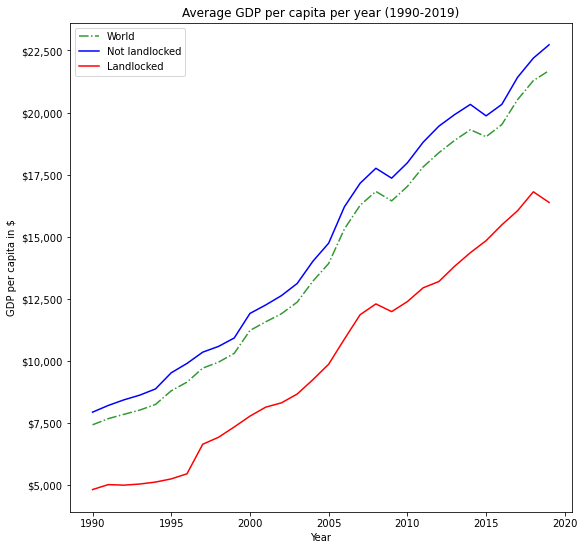

In [16]:
fig, ax = plt.subplots(1,1,figsize = (9,9))
plt.plot("date", "gdp_total", data = meangdp_year, linestyle = "dashdot", color = "green", alpha = 0.8, label = "World")
plt.plot("date", "gdp_notlandlocked", data = meangdp_year, color = "blue", label = "Not landlocked")
plt.plot("date", "gdp_landlocked", data = meangdp_year, color = "red", label = "Landlocked")
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
plt.xlabel("Year")
plt.ylabel("GDP per capita in $")
plt.title("Average GDP per capita per year (1990-2019)")
plt.legend()

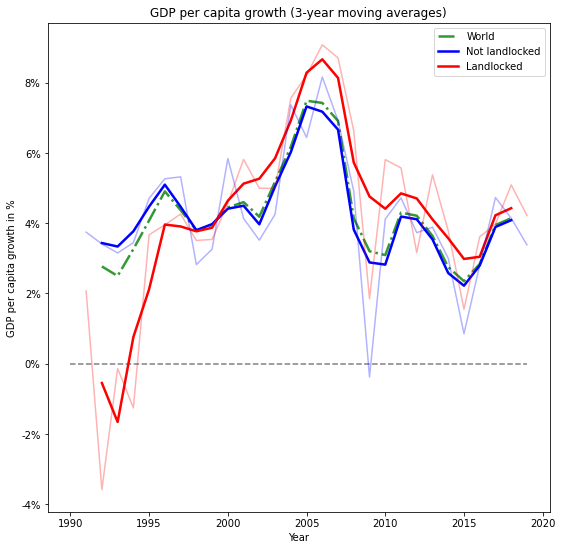

In [17]:
fig, ax = plt.subplots(1,1,figsize = (9,9))
plt.plot("date", "gdp_total_growth_ma", data = meangdp_year,linestyle = "dashdot", color = "green", linewidth = 2.5, alpha = 0.8, label = "World")
plt.plot("date", "gdp_notlandlocked_growth_ma", data = meangdp_year, color = "blue", linewidth = 2.5, label = "Not landlocked")
plt.plot("date", "gdp_landlocked_growth_ma", data = meangdp_year, color = "red", linewidth = 2.5, label = "Landlocked")
#plt.plot("date", "gdp_total_growth", data = meangdp_year, color = "green", alpha = 0.3, label = "_nolegend_")
plt.plot("date", "gdp_notlandlocked_growth", data = meangdp_year, color = "blue", alpha = 0.3, label = "_nolegend_")
plt.plot("date", "gdp_landlocked_growth", data = meangdp_year, color = "red", alpha = 0.3, label = "_nolegend_")
plt.hlines(0, min(meangdp_year["date"]), max(meangdp_year["date"]), linestyle = "dashed", color = "gray")
ax.yaxis.set_major_formatter(ticker.FuncFormatter('{:,.0%}'.format))
plt.xlabel("Year")
plt.ylabel("GDP per capita growth in %")
plt.title("GDP per capita growth (3-year moving averages)")
plt.legend()